# [Machine Learning](https://github.com/frolovilya/machine-learning/#machine-learning) / Neural Networks

> See sources
> * [neural_network.py](https://github.com/frolovilya/machine-learning/blob/master/neural_network.py)
> * [optimize.py](https://github.com/frolovilya/machine-learning/blob/master/optimize.py)
> * [image_recognition.py](https://github.com/frolovilya/machine-learning/blob/master/image_recognition.py)
> * [utils.py](https://github.com/frolovilya/machine-learning/blob/master/utils.py)

In [1]:
# load libs
import sys
sys.path.append("../")

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math
from neural_network import *
from image_recognition import *
from utils import *
from optimize import find_coefficients

Neural network consists of L total layers: 1 input layer ($x^{(0)}$), $L - 2$ hidden layers ($a^{(1)} ... a^{(l - 1)}$) and 1 output layer ($a^{(L)}$):

$$
\begin{bmatrix}
x^{(0)}_{0}\\
x^{(0)}_{1}\\
x^{(0)}_{2}
\end{bmatrix}
\begin{bmatrix}
a^{(1)}_{0}\\
a^{(1)}_{1}\\
a^{(1)}_{2}\\
a^{(1)}_{3}\\
a^{(1)}_{4}\\
\end{bmatrix}
...
\begin{bmatrix}
a^{(l - 1)}_{0}\\
a^{(l - 1)}_{1}\\
a^{(l - 1)}_{2}\\
a^{(l - 1)}_{3}\\
a^{(l - 1)}_{4}\\
\end{bmatrix}
\begin{bmatrix}
a^{(L)}_{0}\\
a^{(L)}_{1}\\
a^{(L)}_{2}\\
\end{bmatrix}
$$

Each layer's unit is a logistic regression classifier and connected to the next layer's units with edges of weight $\theta^{(l)}_{ij}$.

## Forward Propagation

Propagating values from left to right to calculate output layer's values.

Input layer:

$$a^{(0)} = X$$

Hidden and output layers:

$$a^{(l + 1)} = g((\Theta^{(l)})^T a^{(l)})$$

where $g$ is a logistic regression sigmoid function.

In [2]:
# load neural network data and weights
def load_neural_network_data():
    return scipy.io.loadmat('../data/ex3data1.mat')


def load_neural_network_weights():
    return scipy.io.loadmat('../data/ex3weights.mat')


neura_network_data = load_neural_network_data()
x = neura_network_data['X']  # m x n^2, where m - experiments count, n - square image size
y = neura_network_data['y']  # m x 1 vector of image classes (numbers 0 - 9)

weights = load_neural_network_weights()
nn_coefficients = (
    weights['Theta1'],  # S1 x (n^2 + 1), where S1 - hidden layer size, n - square image size
    weights['Theta2']   # SL x (S1 + 1), where SL - output layer size, S1 - hidden layer size
)

Predicting digits using already pre-trained neural network $\Theta$ weights.

In [3]:
# predict images
nn_predictions = [predict_digit(nn_coefficients, image.reshape(image.size, 1)) for image in x]
print_predictions_accuracy(nn_predictions, y)

Prediction accuracy = 97.52%


[6, 7, 6, 6, 4, 4, 4, 6, 4, 1, 6, 4, 3, 7, 5, 4, 5, 8, 7, 8]


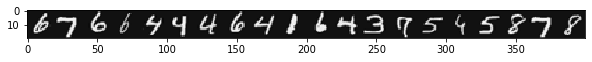

In [4]:
predict_random_images(nn_predictions, x)

## Cost Function

Given that $L$ - number of layers, $s_l$ - number of units in layer $l$:

$$J(\Theta) = - \frac{1}{m} \sum_{i=0}^{m} \sum_{k=0}^{S_L} 
        [{ y^{(i)}_k log(h(X^{(i)})_k) + (1 - y^{(i)}_k) log(1 - h(X^{(i)})_k) }] 
    + \frac{\lambda}{2 m} \sum_{l=0}^{L} \sum_{i=0}^{s_l} \sum_{j=1}^{s_i} (\theta^{(l)}_{ij})^2$$
    
Calculating cost function as a sum of the last layer's cost functions regularized over all $\Theta^{(l)}_{ij}$ coefficient values.

In [5]:
# check cost function value for provided neural network coefficients
def digit_to_output_vector(digit):
    """
    Returns 10 x 1 vector with all 0 except 1 for index corresponding to the provided digit.
    If digit == 0, then 10th element == 1.
    """
    out = np.zeros(10)
    out[9 if digit == 0 else digit - 1] = 1
    return out


expected_output = np.array([digit_to_output_vector(d) for d in y]).transpose()
nn_cost_function(nn_coefficients, x.transpose(), expected_output)

0.287629165161319

In [6]:
# check regularized cost function value for provided neural network coefficients
original_shape, unrolled_nn_coefficients = unroll_list_of_matrices_to_vector(nn_coefficients)

nn_regularized_cost_function(unrolled_nn_coefficients, x.transpose(), expected_output, 1, original_shape)

0.38448779624289403

## Backpropagation Algorithm

Is used to calculate cost function first derivative over all l, i, j:
$$\frac{dJ}{d\Theta^{(l)}_{ij}}$$

Lets introduce cost function error $\delta^{(l)}$ for each layer $l$ and propagate this value from right to left.

For the last layer $L$: 
$$\delta^{(L)} = a^{(L)} - y$$

For $[2, L-1]$ layers:
$$\delta^{(l)} = (\Theta^{(l)})^T \delta^{(l + 1)} \cdot g^{'}(z^{(l)})$$

Recall that: 
$$a^{(l)} = g(z^{(l)}) = \frac{1}{1 + e^{-z^{(l)}}}$$

$$z^{(l)} = (\Theta^{(l - 1)})^T a^{(l - 1)}$$

And sigmoid function's first derivative: 
$$g^{'}(z^{(l)}) = g(z^{(l)}) \cdot (1 - g(z^{(l)})) = a^{(l)} \cdot (1 - a^{(l)})$$

Shows sensitivity of the sigmoid function to the change in input $z$.

Then:
$$\delta^{(l)} = (\Theta^{(l)})^T \delta^{(l + 1)} \cdot a^{(l)} \cdot (1 - a^{(l)})$$

Each $\delta^{(l)}$ contributes to the total layer's delta:
$$\Delta^{(l)} := \Delta^{(l)} + \delta^{(l + 1)} (a^{(l)})^T$$

Then $J(\Theta)$ first derivative can be calculated as:
$$\frac{dJ}{d\Theta^{(l)}_{ij}} = \frac{1}{m} \Delta^{(l)}_{ij}, j = 0$$

$$\frac{dJ}{d\Theta^{(l)}_{ij}} = \frac{1}{m} \Delta^{(l)}_{ij} 
    + \frac{\lambda}{m}\Theta^{(l)}_{ij}, j \gt 0$$

Train neural network, find coefficients:

In [7]:
original_shape = ((25, 401), (10, 26))
initial_coefficients = np.random.uniform(-0.12, 0.12, 25*401 + 10*26)

coefficients_vector = find_coefficients(x.transpose(), expected_output,
                                        nn_regularized_cost_function, nn_regularized_gradient,
                                        regularization_rate=1, 
                                        max_iterations=50, 
                                        initial_coefficients=initial_coefficients,
                                        additional_args=(original_shape,))

nn_learned_coefficients = roll_vector_to_list_of_matrices(coefficients_vector, original_shape)

In [8]:
nn_new_predictions = [predict_digit(nn_learned_coefficients, image.reshape(image.size, 1)) for image in x]
print_predictions_accuracy(nn_new_predictions, y)

Prediction accuracy = 96.92%


[8, 9, 2, 3, 1, 0, 1, 9, 5, 4, 3, 7, 0, 4, 8, 4, 8, 9, 3, 6]


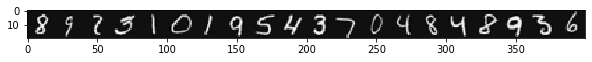

In [9]:
predict_random_images(nn_new_predictions, x)